PyImageJ Tutorial
===

This notebook covers how to use ImageJ as a library from Python. A major advantage of this approach is the ability to combine ImageJ with other tools available from the Python software ecosystem, including NumPy, SciPy, scikit-image, CellProfiler, OpenCV, ITK and more.

This notebook assumes familiarity with the ImageJ API. Detailed tutorials in that regard can be found in the other notebooks.

## 6 Working with Images

These methods can be helpful, especially if you do not know beforehand of which type your image is. First lets initialize ImageJ, import some packages and load in some test data.

In [1]:
import imagej

# initialize ImageJ2
ij = imagej.init(mode='interactive')
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.5.0/1.53r


### 6.1 Opening images with `ij.io().open()`

Images can be opened with ImageJ with `ij.io().open()`. This returns the opened image as an ImageJ2 `Dataset` (a Java object). Using `ij.io().open()` allows you to take advantage of the `Bio-Formats` image read/write and `SCIFIO` image conversion when using Fiji endpoints (_e.g._ `sc.fiji:fiji`). Lets load some data:

In [2]:
# load local test data
dataset = ij.io().open('sample-data/test_timeseries.tif')

# load web test data
web_image = ij.io().open('https://wsr.imagej.net/images/Cell_Colony.jpg')

[INFO] Populating metadata


[java.lang.Enum.toString] [INFO] Populating metadata


You can view images with `ij.py.show()`. Note that `dataset` is 4D (see the next section) and will not be viewable via `ij.py.show()`. The `show()` method expects a simple 2D image. You can view 4D data in ImageJ's viewer with `ij.ui().show()` (this only works locally with `mode='interactive'`). In section 5.3 we will slice `dataset` to extract a single 2D image to view with `ij.py.show()`.

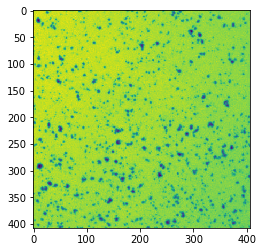

In [3]:
# show the web image
ij.py.show(web_image)

In [4]:
# show the 4D dataset in ImageJ's viewer
ij.ui().show(dataset)

### 6.2 Working with image dimensions and shape

The sample data `test_timeseries.tif` is a 4D (X, Y, Channel, Time) dataset of a HeLa cell infected with a modified HIV-1 fluorescent reporter virus. This reporter virus is designed to express two flourscent proteins upon viral gene expression. Here is the breakdown of the channels:

| Channel | psedu-color | purpose |
| :---: | :---: | :---: |
| 1 | Blue | Nuclear marker |
| 2 | Red | Early viral gene expression |
| 3 | Green | Late viral gene expression / viral particle formation |

We can get the shape and dimensions of the Java data by printing the `.shape` and `.dims` property:

In [5]:
print(f"shape: {dataset.shape}")
print(f"dimensions: {dataset.dims}")

shape: (250, 250, 3, 15)
dimensions: ('X', 'Y', 'Channel', 'Time')


The same methods can also be used on Python objects as well (where dimension information is available):

In [6]:
# convert the ImageJ image (Java) to an xarray.DataArray (Python)
xarr = ij.py.from_java(dataset)

print(f"shape: {xarr.shape}")
print(f"dimensions: {xarr.dims}")

shape: (15, 250, 250, 3)
dimensions: ('t', 'row', 'col', 'ch')


**Important**: Note the difference in shape and dimension order between the ImageJ and xarray images. ImageJ images use `[X, Y, Channel, Z, Time]` dimension labels and order. NumPy images use `[t, pln, row, col, ch]` Where `row` and `col` correspond to `Y` and `X` respectively.

Its also important to note that not all images objects (Java and Python) have dimension metadata.

In [7]:
# print dataset (Java) shape and dims
print(f"Java data shape: {dataset.shape}")
print(f"Java data dims: {dataset.dims}\n")

# print xarray (Python) shape and dims
print(f"Python data shape: {xarr.shape}")
print(f"Python data dims: {xarr.dims}")

Java data shape: (250, 250, 3, 15)
Java data dims: ('X', 'Y', 'Channel', 'Time')

Python data shape: (15, 250, 250, 3)
Python data dims: ('t', 'row', 'col', 'ch')


### 6.3 Slicing Python and Java images

Let's slice and view the test data. Note the change in dimension order depending on the object you are working with.

In [8]:
# slice the test data
java_slice = dataset[:, :, 1, 10]
python_slice = xarr[10, :, :, 1]

# print slice shape
print(f"java_slice: {java_slice.shape}")
print(f"python_slice: {python_slice.shape}")

java_slice: (250, 250)
python_slice: (250, 250)


**Important**: When you slice an ImageJ image (_i.e._ a `RandomAccessibleInterval`) an `IntervalView` is returned. Depending on what you're doing this object type could be and you can continue with your workflow. In this case however, we need to wrap/convert the `IntervalView` returned from the slicing operation as an `ImgPlus`. Then we can use `ij.py.show()` to view the slice. For more information on `RandomAccessibleIntervals` check out the ImageJ wiki [here](https://imagej.net/libs/imglib2/accessibles).

java_slice type: <java class 'net.imglib2.view.IntervalView'>


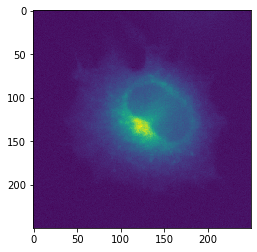

In [9]:
print(f"java_slice type: {type(java_slice)}")

# wrap as ImgPlus -- you can also wrap the slice as a dataset with ij.py.to_dataset()
img = ij.py.to_img(java_slice)
ij.py.show(img)

python_slice type: <class 'xarray.core.dataarray.DataArray'>


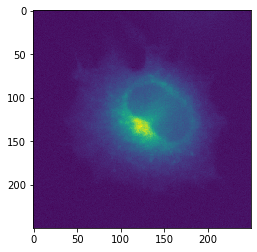

In [10]:
print(f"python_slice type: {type(python_slice)}")

# xarray images can just be displayed
ij.py.show(python_slice)

### 6.4 Combine slices

With `xarray` you can combine slices easily using the `.concat()` operation. Let's take two slices from the 4D dataset and create a new 3D xarray.

In [11]:
# get two slices from the test dataset
xarr_slice1 = xarr[12, :, :, 1]
xarr_slice2 = xarr[12, :, :, 2]

# these slices should only be 2D (i.e. x,y)
print(f"s1 shape: {xarr_slice1.shape}")
print(f"s2 shape: {xarr_slice2.shape}")

s1 shape: (250, 250)
s2 shape: (250, 250)


Import `xarray` and combine the two extracted frames.

In [12]:
import xarray as xr

# note that you must specify which coordnate ('dim') to concatenate on
new_stack = xr.concat([xarr_slice1[:,:], xarr_slice2[:,:]], dim='ch')

Now we can check the dimensions of the new 3D image.

In [13]:
print(f"Number of dims: {len(new_stack.dims)}\ndims: {new_stack.dims}")

Number of dims: 3
dims: ('ch', 'row', 'col')


`ij.py.show()` only displays 2D images, not 3D ones like `new_stack`. But we can view both slices of `new_stack` like so:

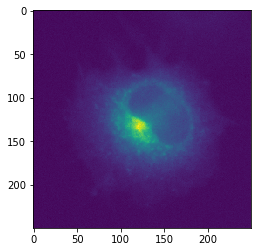

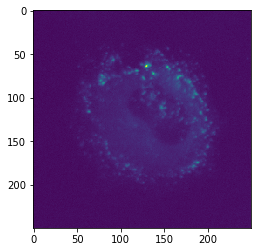

In [14]:
# view the data
ij.py.show(new_stack[0])
ij.py.show(new_stack[1])

Remeber we can send `new_stack` back to ImageJ/Java with `ij.py.to_java()` for further analysis

In [15]:
# send new_stack back to ImageJ/Java
img = ij.py.to_java(new_stack)
print(f"img dims: {img.dims}\nimg shape: {img.shape}")

img dims: ('X', 'Y', 'Channel')
img shape: (250, 250, 2)


You can also combine slices from ImageJ images using ImgLib2's `Views.stack()` function. `stack` accepts two or more n-dimensional `RandomAccessibleIntervals` of the same size and returns a (n+1)-dimensional `RandomAccessibleInterval` where the last dimension is the index of the input hyperslices.

First lets use `scyjava` to import the `net.imglib2.view.Views` class. You can learn more about this specific class and other ImgLib2 classes at the [ImgLib2 Javadoc](https://javadoc.scijava.org/ImgLib2/).

In [16]:
import scyjava as sj

Views = sj.jimport('net.imglib2.view.Views')

Next lets slice the original dataset (dimensions:  X, Y, Channel, Time) to extract two slices to combine into a new stack.

In [17]:
jslice_1 = dataset[:, :, 1, 12]
jslice_2 = dataset[:, :, 2, 12]
print(f"slice 1 shape: {jslice_1.shape}\nslice 2 shape: {jslice_2.shape}")

slice 1 shape: (250, 250)
slice 2 shape: (250, 250)


Now we can use `Views` to combine the two slices into a new stack.

In [18]:
jstack = Views.stack(jslice_1, jslice_2)
print(f"stack shape: {jstack.shape}")

stack shape: (250, 250, 2)


Note the new 3rd dimension, the index of the slices (_i.e._ the channel dimension).

Finally we can view the contents of the new stack:

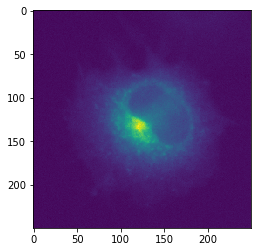

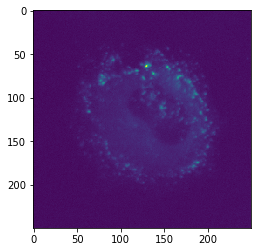

In [19]:
# view the two slices jstack
ij.py.show(ij.py.to_img(jstack[:, :, 0]))
ij.py.show(ij.py.to_img(jstack[:, :, 1]))

### 6.5 Create numpy images

`ij.py.initialize_numpy_image()` takes a single image argument and returns a NumPy array of zeros in the same shape as the input image. This method is used internally when sending/recieving data with `ij.py.to_java()` and `ij.py.from_java()` to initialize a destination NumPy array. An important nuance to know is that `RandomAccessibleIntervals` passed to `initialize_numpy_image()` will return a NumPy array with a **reversed** shape. When passing `xarray.DataArray` or `numpy.ndarray` images will return a NumPy array of zeros in the **same** shape as the input array.

In [20]:
# initialize a new numpy array with numpy array
new_arr1 = ij.py.initialize_numpy_image(xarr.data)

# initialize a new numpy array with xarray
new_arr2 = ij.py.initialize_numpy_image(xarr)

# initialize a numpy array with RandomeAccessibleInterval
new_arr3 = ij.py.initialize_numpy_image(dataset)

print(f"xarr/numpy shape: {xarr.shape}\ndataset shape: {dataset.shape}")
print(f"new_arr1 shape: {new_arr1.shape}\nnew_arr2 shape: {new_arr2.shape}\nnew_arr3 shape: {new_arr3.shape}")

xarr/numpy shape: (15, 250, 250, 3)
dataset shape: (250, 250, 3, 15)
new_arr1 shape: (15, 250, 250, 3)
new_arr2 shape: (15, 250, 250, 3)
new_arr3 shape: (15, 3, 250, 250)


Note that both `new_arr1` and `new_arr2` have the same shape as the source `xarr`. `new_arr3` however has reversed dimensions relative to `dataset` (a `RandomAcessibleInterval`).

### 6.6 Working with ops

PyImageJ also grants easy access to `imagej-ops`. Using `ij.py.to_java()` to convert Python objects into Java ones for ops allows you to utilize the full power of `imagej-ops` on Python-based `xarray.DataArray` and `numpy.ndarray` data.

In [21]:
import numpy as np

arr1 = np.array([[1, 2], [3, 4]])
arr2 = np.array([[5, 6], [7, 8]])
arr_output = ij.py.initialize_numpy_image(arr1)

ij.op().run('multiply', ij.py.to_java(arr_output), ij.py.to_java(arr1), ij.py.to_java(arr2))
print(arr_output) # this output will be [[5, 12], [21, 32]]

[[ 5 12]
 [21 32]]


### 6.7 Window service and manipulating windows

In order to use a graphical user interface, you must also initialize PyImageJ with `mode='gui'` or `mode='interactive'`. To work with windows, you can:

* Use ImageJ2's
  [`WindowService`](https://javadoc.scijava.org/ImageJ/net/imagej/display/WindowService.html) through `ij.window()`.

* Use the original ImageJ's
[`WindowManager`](https://javadoc.scijava.org/ImageJ1/index.html?ij/WindowManager.html) using the `ij.WindowManager` property.

Please note that the original ImageJ's `WindowManager` was not designed to operate in a headless enviornment, thus some functions my not be supported.

You can get a list of active ImageJ2 windows with the following command:

In [22]:
print(ij.window().getOpenWindows())

[test_timeseries.tif]


To close windows use this command:

In [23]:
ij.window().clear()